In [149]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os

In [150]:
df = pd.read_csv("./../res/bagging_sa_params.csv")

df_agg = df.groupby(["dataset", "test_split_amount", "fmc"]).agg(
    dataset=("dataset", "first"),
    test_split_amount=("test_split_amount", "first"),
    fmc=("fmc", "first"),
    accuracyMean=("accuracy", "mean"),
    accuracyStd=("accuracy", "std"),
    fitnessMean=("fitness", "mean"),
    fitnessStd=("fitness", "std"),
    accFitnessDifferenceMean=("accFitnessDifference", "mean"),
    accFitnessDifferenceStd=("accFitnessDifference", "std"),
).reset_index(drop=True)


df_cor = df[df['spearmanP'] < 0.05].groupby(["dataset", "test_split_amount", "fmc"]).agg(
    dataset=("dataset", "first"),
    test_split_amount=("test_split_amount", "first"),
    fmc=("fmc", "first"),
    correlationMean=("correlation", "mean"),
    correlationStd=("correlation", "std"),
).reset_index(drop=True)

df_agg = df_agg.merge(df_cor, on=["dataset", "test_split_amount", "fmc"], how="left")

df_agg.to_csv("./../res/bagging_sa_params_aggregated.csv", index=False)
df = df_agg.copy()

In [151]:
def get_alpha_fmc_for_min_error(df: pd.DataFrame, dataset: str) -> Tuple[float, float]:
    tmp_df = df[df['dataset'] == dataset]
    X1 = tmp_df['test_split_amount'].values
    X2 = tmp_df['fmc'].values
    Y1 = tmp_df['fitnessMean'].values
    Y2 = tmp_df['correlationMean'].values
    
    error = np.sqrt((1-Y2)**2 + (1-Y1)**2)
    min_error_index = np.argmin(error)
    test_split_amount = X1[min_error_index]
    fmc = X2[min_error_index]
    return test_split_amount, fmc

c:\Personal\TMP\SimulatedAnnealingBagging\.venv\Lib\site-packages\matplotlib\colors.py:2243: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\Personal\TMP\SimulatedAnnealingBagging\.venv\Lib\site-packages\matplotlib\colors.py:2250: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\string.py:264: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return format(value, format_spec)
c:\Personal\TMP\SimulatedAnnealingBagging\.venv\Lib\site-packages\matplotlib\colors.py:2243: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\Personal\TMP\SimulatedAnnealingBagging\.venv\Lib\site-packages\matplotlib\colors.py:2250: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(val

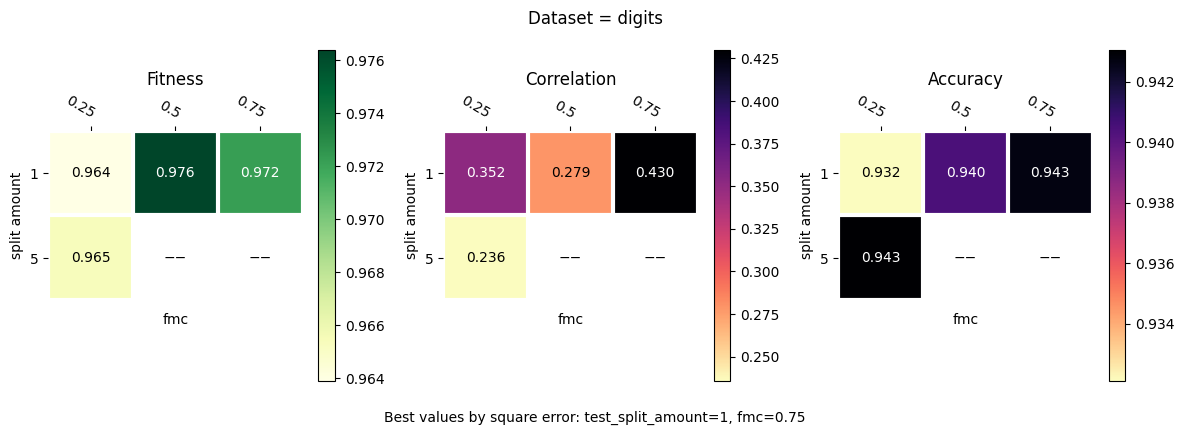

In [152]:
def create_heatmap_for_dataset(df: pd.DataFrame, dataset: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
    
    tmp = df[df['dataset'] == dataset]
    X = tmp['test_split_amount'].unique()
    Y = tmp['fmc'].unique()
    Z1 = tmp.pivot_table(index='test_split_amount', columns='fmc', values='fitnessMean').values
    Z2 = tmp.pivot_table(index='test_split_amount', columns='fmc', values='correlationMean').values
    Z3 = tmp.pivot_table(index='test_split_amount', columns='fmc', values='accuracyMean').values
    
    
    
    ax[0].set_title(f"Fitness")
    ax[0].set_xlabel("fmc")
    ax[0].set_ylabel("split amount")
    im, cbar = heatmap(Z1, X, Y, ax=ax[0], cmap="YlGn", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")

    ax[1].set_title(f"Correlation")
    ax[1].set_xlabel("fmc")
    ax[1].set_ylabel("split amount")
    im, cbar = heatmap(Z2, X, Y, ax=ax[1], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    ax[2].set_title(f"Accuracy")
    ax[2].set_xlabel("fmc")
    ax[2].set_ylabel("split amount")
    im, cbar = heatmap(Z3, X, Y, ax=ax[2], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    
    fig.suptitle(f"Dataset = {dataset}")
    fig.tight_layout()
    best_test_split_amount, best_fmc = get_alpha_fmc_for_min_error(df, dataset)

    plt.figtext(0.5, -0.05, f"Best values by square error: test_split_amount={best_test_split_amount}, fmc={best_fmc}", 
                wrap=False, horizontalalignment='center', fontsize=10)
    plt.show()
    

datasets = df['dataset'].unique()    
for dataset in datasets:
    create_heatmap_for_dataset(df, dataset)

# RESULT COMPARISON PLOTS  

In [153]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        # ("DT", "Decision tree"),
        ("Bagging", "Bagging"),
        # ("BaggingCustom", "Bagging custom"),
        # ("RF", "Random forrest"),
        ("BaggingSA", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "_STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"Accuracy per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    plt.show()
    
    

+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| Dataset | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| digits  |   10   | 0.857 |  0.928  | 0.949 |     0.923     |   0.94    | 0.017  |    0.016    | 0.009  |       0.017       |     0.022     |
| digits  |   20   | 0.859 |  0.936  | 0.965 |     0.941     |   0.947   | 0.018  |    0.017    | 0.012  |       0.015       |     0.021     |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+


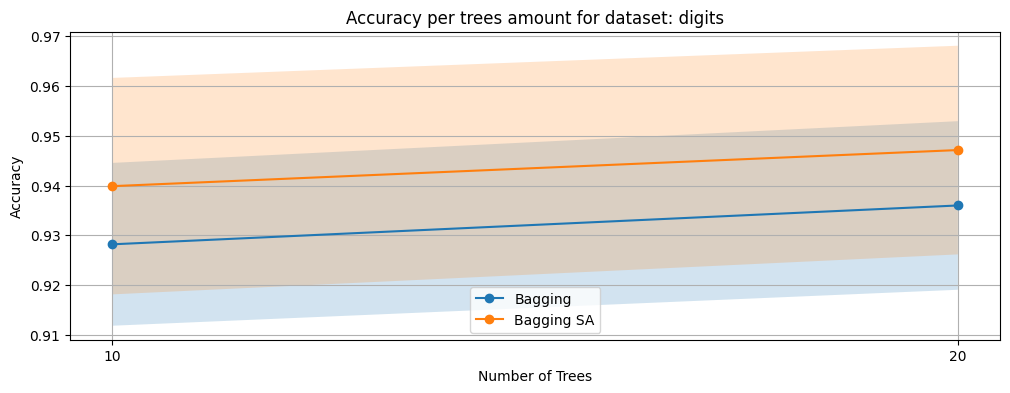

In [154]:
from tabulate import tabulate


files = glob.glob('./../res/accuracy_comparison_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        Dataset=('Dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        DT=('DT', 'mean'),
        Bagging=('Bagging', 'mean'),
        RF=('RF', 'mean'),
        BaggingCustom=('BaggingCustom', 'mean'),
        BaggingSA=('BaggingSA', 'mean'),

        DT_STD=('DT','std'),
        Bagging_STD=('Bagging','std'),
        RF_STD=('RF','std'),
        BaggingCustom_STD=('BaggingCustom','std'),
        BaggingSA_STD=('BaggingSA','std'),
    ).reset_index(drop=True).dropna()
    
    tmp = df_aggregated.copy().round(3)
    print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))
    create_comparison_plot(df_aggregated)
    print()
    
    